In [34]:
import pandas as pd
import os, sys
import subprocess
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib
import numpy as np
import re
from colour import Color

In [35]:
# Inputfolder & files
inputfolder = f"../Data"
remove_na="all"

# Clean version of load data

## Nakamura dataset

In [36]:
sismic_events = ["_dm_", "_sm_", "_ai_", "_m_"]

In [37]:
nakamura_files = os.listdir(f"../Data")
nakamura_files = [file for file in nakamura_files if "nakamura" in file]

nakamura_files_per_event = {}
for event in sismic_events: nakamura_files_per_event[event[1:-1]] = [file for file in nakamura_files if event in file]

In [38]:
nakamura_files_per_event

{'dm': ['nakamura_2005_dm_locations.csv', 'nakamura_2005_dm_arrivals.csv'],
 'sm': ['nakamura_1983_sm_arrivals.csv', 'nakamura_1979_sm_locations.csv'],
 'ai': ['nakamura_1983_ai_locations.csv', 'nakamura_1983_ai_arrivals.csv'],
 'm': ['nakamura_1983_m_arrivals.csv']}

In [39]:
possible_type_indexes = ["A", "AI"]
for event in nakamura_files_per_event.keys():
    
	arrivals_file = [file for file in nakamura_files_per_event[event] if "arrivals" in file]
	if len(arrivals_file) != 0: arrivals = pd.read_csv(f"{inputfolder}/{arrivals_file[0]}", index_col=0)
	else: continue
 
	locations_file = [file for file in nakamura_files_per_event[event] if "locations" in file]
	if len(locations_file) != 0: locations = pd.read_csv(f"{inputfolder}/{locations_file[0]}", index_col=0)
	else: continue
	locations["Type"] = event
 
	if (not arrivals.index.name == "A") and (not arrivals.index.name == "AI"):
		locations = locations.reset_index()
		arrivals = arrivals.reset_index()
		locations_arrivals = locations.merge(arrivals, on=["Year", "Day"], how="outer")
		locations_arrivals.to_csv(f"{inputfolder}/nakamura_locations_arrivals_{event}.csv", index=False)
		locations_arrivals
  
	for index in possible_type_indexes:
		if index == arrivals.index.name: 
			locations_arrivals = locations.merge(arrivals, on=index, how="outer")
			locations_arrivals.to_csv(f"{inputfolder}/nakamura_locations_arrivals_{event}.csv", index=False)	

In [40]:
# Nakamura datasets Latitude, Longitude and Depth for 2D heatmap
columns_of_interest=["Lat","Long","Depth","Type"]

nakamura_per_event=pd.DataFrame(columns=columns_of_interest)
for event in sismic_events: 
    
    # Verify presence of file to read
    if os.path.exists(f"{inputfolder}/nakamura_locations_arrivals_{event[1:-1]}.csv"): nakamura_locations_arrivals = pd.read_csv(f"{inputfolder}/nakamura_locations_arrivals_{event[1:-1]}.csv")
    else: continue
    
    # Verify presence of all needed columns
    try: 
        nakamura_locations_arrivals = nakamura_locations_arrivals[columns_of_interest]
    except KeyError:
        continue
        
    nakamura_per_event = pd.concat([nakamura_per_event,nakamura_locations_arrivals])

# Drop rows where there are no values
nakamura_per_event = nakamura_per_event.dropna(axis=0, how=remove_na)
nakamura_per_event.to_csv(f"{inputfolder}/nakamura_per_event_for_heatmap.csv", index=False)

## Process dataframe Lognonné

In [41]:
# To compute the x,y,z coordinates of our 3D Moon sphere
sphere_radius = 10

In [42]:
def white_to_blue_rgb(minimum, maximum, value):
    minimum, maximum = float(minimum), float(maximum)
    r = 0
    g = 0
    b = 255 * (value/maximum)
    return r, g, b

In [44]:
# Integer values of depth
def white_to_blue_hex(list_of_values):
    
    dict_value_to_colour = {}
    
    n_values = int(max(list_of_values)-min(list_of_values))
    
    white = Color("white")
    colors = list(white.range_to(Color("blue"), n_values))
    
    for value in list_of_values:
        if not np.isnan(value):
            dict_value_to_colour[int(value)] = colors[int(value)-1]
        
    return dict_value_to_colour

In [45]:
# Load dataset and upload new columns
lognonne_df = pd.read_csv(f"{inputfolder}/lognonne_2003_catalog.csv")

# transform Lat, Long to radians
lognonne_df["Latrad"] = lognonne_df["Lat"]*(np.pi/180)
lognonne_df["Longrad"] = lognonne_df["Long"]*(np.pi/180)

lognonne_df["original_type"] = lognonne_df["Type"]
new_columns = ["Year", "Month", "Day", "Hour", "Minute", "hex"]
for column in new_columns: lognonne_df[column]=0

# compute new coordinates over spherical Moon representation
lognonne_df["zpos"]= sphere_radius * np.cos(lognonne_df["Latrad"]) * np.cos(lognonne_df["Longrad"])
lognonne_df["ypos"]= sphere_radius * np.sin(lognonne_df["Latrad"])
lognonne_df["xps"]= -sphere_radius * np.cos(lognonne_df["Latrad"]) * np.sin(lognonne_df["Longrad"])

# RGB scale based on moonquake depth
# min_depth = lognonne_df["Depth"].min()
# max_depth = lognonne_df["Depth"].max()

# Colour scale for moonquake map
dict_value_to_colour = white_to_blue_hex(lognonne_df["Depth"])

# Process Date column & create RGB column
for row in lognonne_df.itertuples():
	index = row[0]
	depth = lognonne_df.loc[index, "Depth"]
 
	# Date column into Year, Month, etc.
	lognonne_df.loc[index, "Year"] = str(19)+str(lognonne_df.loc[index, "Date"])[0:2]
	lognonne_df.loc[index, "Month"] = str(lognonne_df.loc[index, "Date"])[2:4]
	lognonne_df.loc[index, "Day"] = str(lognonne_df.loc[index, "Date"])[4:6]
	lognonne_df.loc[index, "Hour"] = str(lognonne_df.loc[index, "Date"])[6:8]
	lognonne_df.loc[index, "Minute"] = str(lognonne_df.loc[index, "Date"])[8:]

	# RGB colour scale: from white (superficial) to deep blue (deep moonquake)
	# lognonne_df.loc[index, "R"], lognonne_df.loc[index, "G"], lognonne_df.loc[index, "B"] = white_to_blue_rgb(min_depth, max_depth, depth)
 
	# Hexadecimal colour
	if not np.isnan(depth): lognonne_df.loc[index, "hex"] = dict_value_to_colour[depth]
	else: lognonne_df.loc[index, "hex"] = np.nan
 
	# New type column for classification in histplots
	if re.match("\d", lognonne_df.loc[index, "original_type"]): lognonne_df.loc[index, "Type"] = "AI"
	if re.match("A", lognonne_df.loc[index, "original_type"]): lognonne_df.loc[index, "Type"] = "DM"

# Unneeded columns
lognonne_df=lognonne_df.drop(["Date"], axis=1)

In [46]:
lognonne_df.shape

(59, 38)

In [47]:
lognonne_df.columns

Index(['Type', 'Lat', 'Long', 'Depth', 'Phi', 'Delta-a', 'Delta-b',
       'Depth_err', 'Seconds', 'Time_err', '12P', '12P_EC', '14P', '14P_EC',
       '15P', '15P_EC', '16P', '16P_EC', '12S', '12S_EC', '14S', '14S_EC',
       '15S', '15S_EC', '16S', '16S_EC', 'Latrad', 'Longrad', 'original_type',
       'Year', 'Month', 'Day', 'Hour', 'Minute', 'hex', 'zpos', 'ypos', 'xps'],
      dtype='object')

## 2D heatmap

In [48]:
mydpi=96
transparent=False  # To plot on top of 3D Moon sphere

In [49]:
def heatmap_on_depth(dataset, savename="", transparent=False, mydpi=96):
	cm = plt.cm.get_cmap('RdYlBu')
	fit_scatter = plt.figure(num=0, clear=True, figsize=(1024/mydpi, 512/mydpi))
	sc = plt.scatter(dataset.Lat, dataset.Long, s=10, c=dataset.Depth, cmap=cm)

	if transparent:
		plt.xticks(ticks=[], labels=[])
		plt.yticks(ticks=[], labels=[])
		plt.axis('off')  # command for hiding the axis
		
	else: 
		plt.colorbar(sc)
		plt.ylabel("Latitude")
		plt.xlabel("Longitude")
	
	fit_scatter.savefig(f"../images/moon_heatmap_transparent_{savename}_{transparent}.png", transparent=transparent, dpi=mydpi)

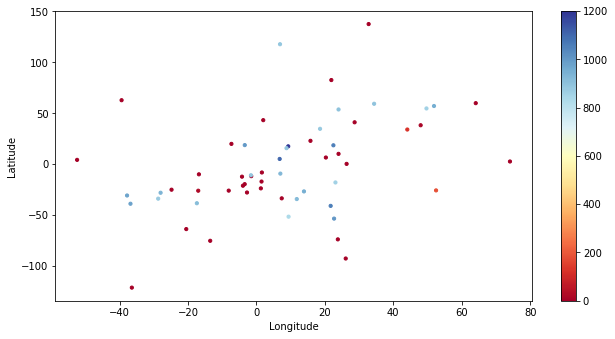

In [50]:
savename = "lognonne_df"
heatmap_on_depth(lognonne_df, savename=savename, transparent=False, mydpi=96)

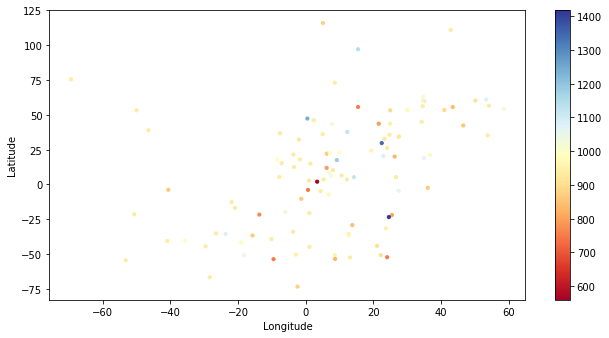

In [51]:
savename = "nakamura"
heatmap_on_depth(nakamura_per_event, savename=savename, transparent=False, mydpi=96)

## Save processed dataframe

In [52]:
recompute = True
if not os.path.exists(f"{inputfolder}/lognonne_2003_catalog_adapted.csv") or recompute:
    lognonne_df.to_csv(f"{inputfolder}/lognonne_2003_catalog_adapted.csv", index=False)
    lognonne_df.to_csv(f"{inputfolder}/lognonne_2003_catalog_adapted_sep_decimal.csv", index=False, sep=";", decimal=",")

## Plots per dataset regarding P,S waves

In [53]:
stations = [12,14,15,16]
remove_na="all"  # rows with all coumns being a NA

In [54]:
print(f"Number of NAs initially: {lognonne_df.isna().sum().sum()}")
lognonne_df_notna = lognonne_df.dropna(axis=0, how=remove_na)
print(f"Number of NAs after processing: {lognonne_df_notna.isna().sum().sum()}")

pwaves = [f"{st}P" for st in stations]
swaves =  [f"{st}S" for st in stations]
lognonne_df_notna_waves = lognonne_df_notna[pwaves+swaves+["Type"]]
print(f"Number of NAs in waves: {lognonne_df_notna_waves.isna().sum().sum()}")

Number of NAs initially: 303
Number of NAs after processing: 303
Number of NAs in waves: 154


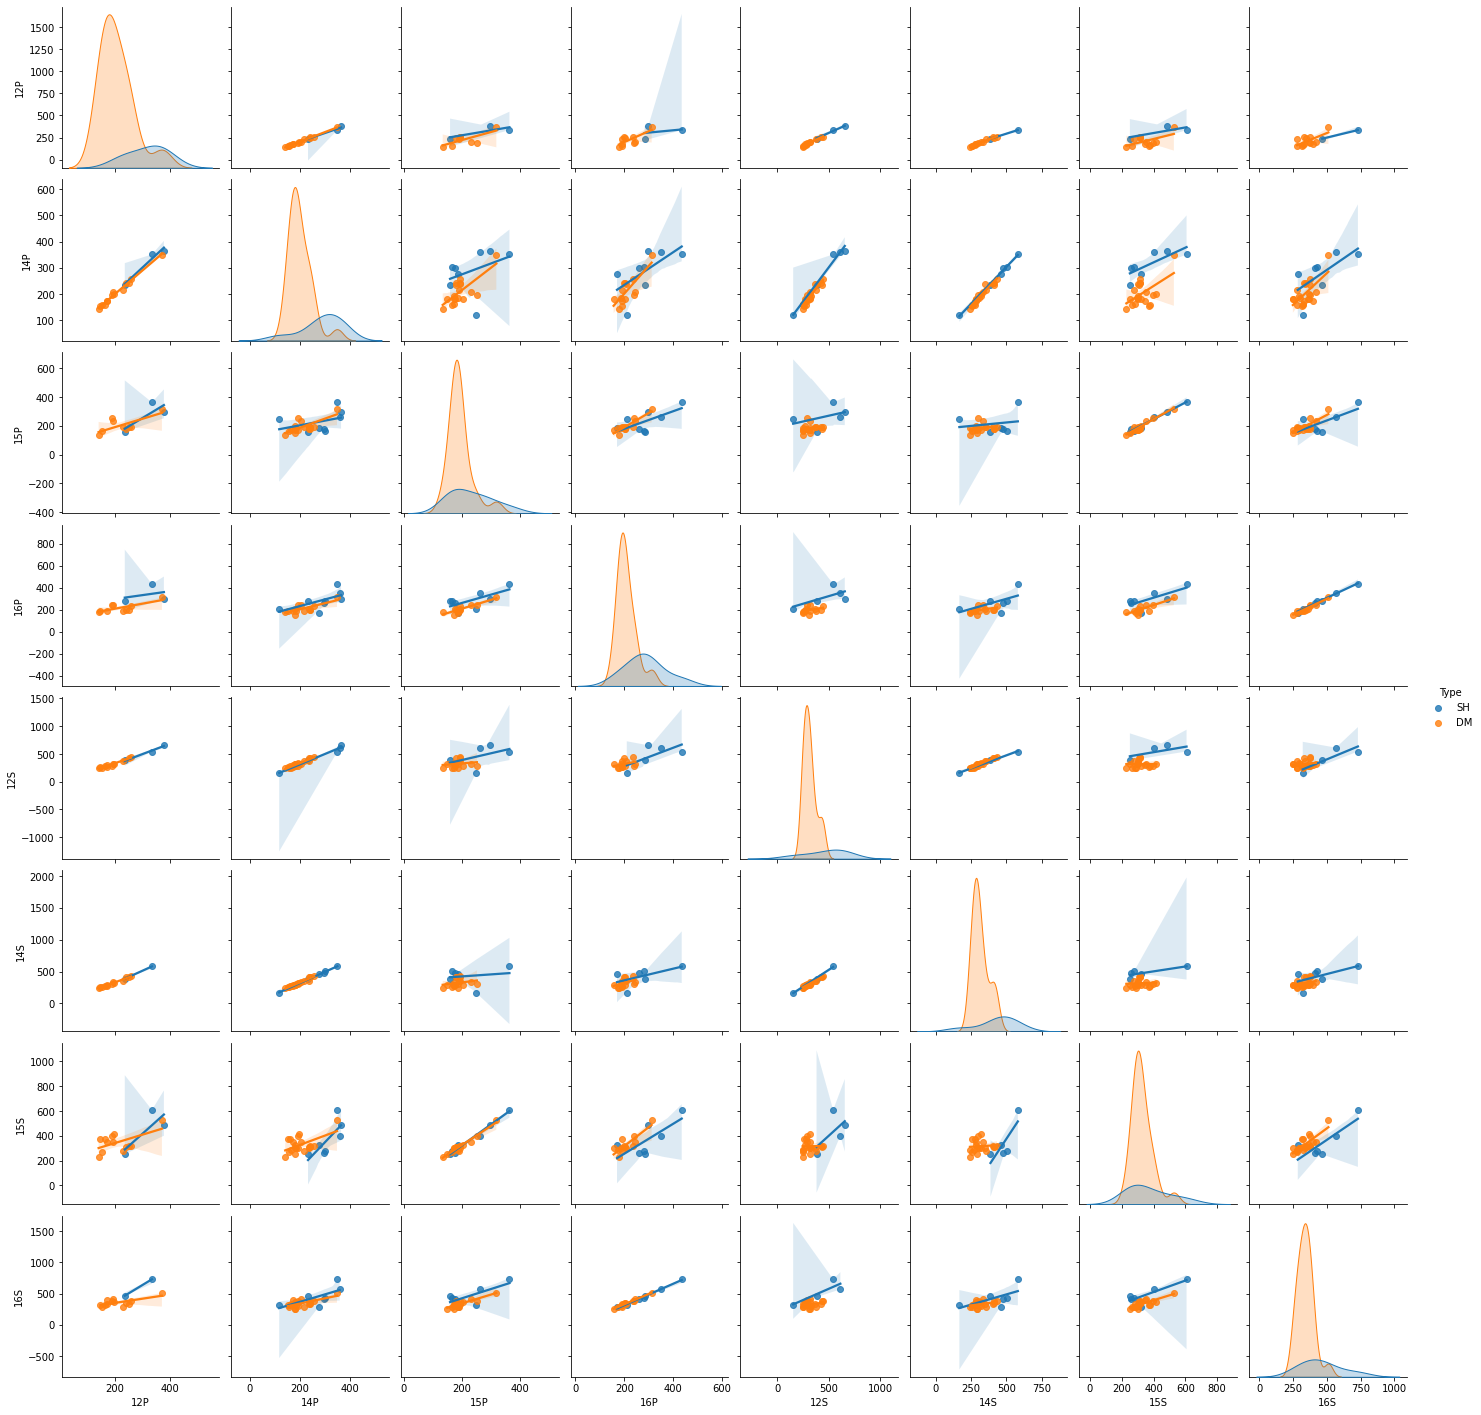

In [55]:
lognonne_df_notna_waves_moonquakes = lognonne_df_notna_waves[lognonne_df_notna_waves["Type"].isin(["DM", "SH"])]
pairgrid = sns.pairplot(lognonne_df_notna_waves_moonquakes, hue="Type", kind="reg")
pairgrid.savefig(f"../images/pairgrid.png", transparent=False, dpi=mydpi)

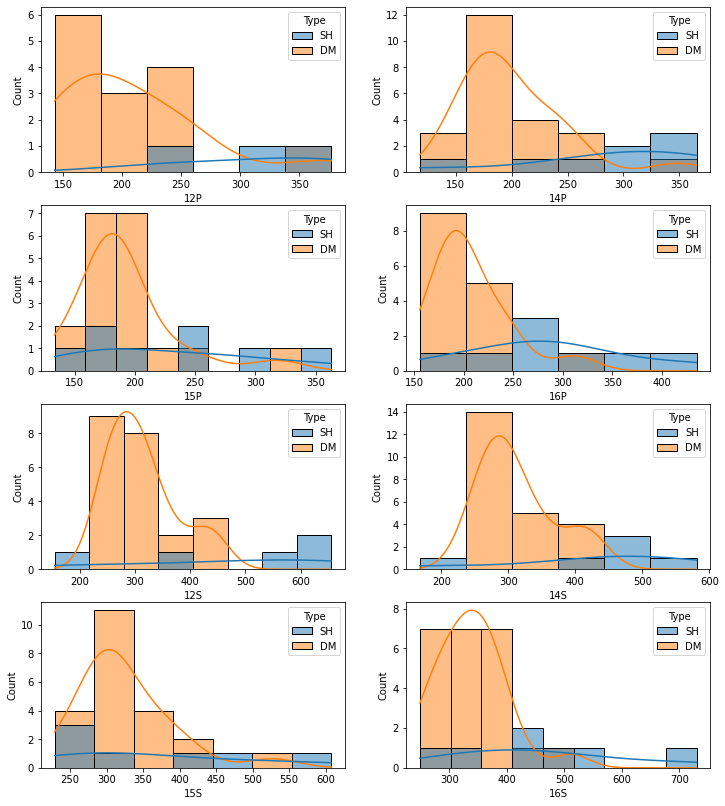

In [56]:
histgrid, ax = plt.subplots(4, 2, figsize=(12,14))
xrow = xcol = 0
for w in pwaves+swaves:
    
    hist=sns.histplot(data=lognonne_df_notna_waves_moonquakes, x=w, ax=ax[xrow,xcol], hue="Type", kde=True, legend=True)
 
    if xcol == 0:
        xcol += 1
    else:
        xcol = 0
        xrow += 1

histgrid.savefig(f"../images/histgrid.png", transparent=False, dpi=mydpi)